# Visualisation and inspection of stability via consensus clustering



In [464]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm


  
  The method step of visalization based on consensus clustering, the method steps can be constructed as follow:(1). For all items, compute the distance matrix via detecting the connectivity of each pairs of items.(2).for different values of K,apply classification algorithms (Spectral clustering,K-medoids or K-means) to compute the adjacency matrix.(3)After resampling several times, compute the consensus matrix for each K(4)visualization of consensus matrix via heatmap and cdf. 

   The experiment aims at detecting the stability of classification algorithms via visualization of consensus clustering, When download all the amazon find food data,  pretreatment and resample procession of data should be down first. 

## 1.pretreatment of data
   There we read the csv file to obtain the related data, in terms of features of users, we consider "scores","HelpfulnessNumerator" and "HelpfulnessDenominator" as the compositions of feature vector.(value of "HelpfulnessNumerator" should be greater or equal to 10）.

In [340]:
import os
import pandas as pd
df = np.load('/Users/dongwen/Desktop/wen dong/original samples.npy')


In [341]:
featureU=df
featureP=np.transpose(df)

  After filtering and preprocessing of data, approximately 2000 rows of items been chosen to form the first sample.based on it, we can make the connective matrix.

## procession of  consensus clustering(K-medoids) without  recommender system
 As the connective given above, we can compute the distance for each pair of items, to represent the distance, we can use $1-r$, whose $r$ represent the spearman correlation, then we compute the distance matrix.it can be achieved by encoding as below:

/Users/Shared/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3162: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/Shared/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3163: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[[ 0.          1.00050025  1.00050025 ...,  1.00050025  1.00070764
   1.00050025]
 [ 1.00050025  0.          1.00050025 ...,  1.00050025  1.00070764
   1.00050025]
 [ 1.00050025  1.00050025  0.         ...,  1.00050025  1.00070764
   1.00050025]
 ..., 
 [ 1.00050025  1.00050025  1.00050025 ...,  0.          0.29307011  0.        ]
 [ 1.00070764  1.00070764  1.00070764 ...,  0.29307011  0.          0.29307011]
 [ 1.00050025  1.00050025  1.00050025 ...,  0.          0.29307011  0.        ]]


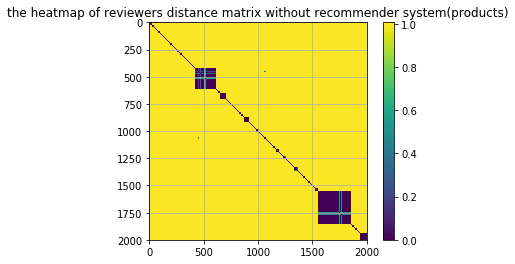

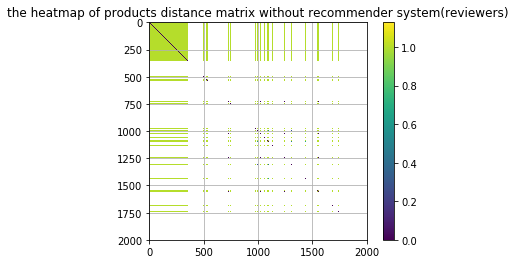

In [339]:

import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
distanceU=1-np.corrcoef(featureU)
distanceP=1-np.corrcoef(featureP)
print(distanceU)
plt.imshow(distanceU, interpolation='nearest')
plt.grid(True)
plt.colorbar()
plt.title('the heatmap of reviewers distance matrix without recommender system(products)')
plt.subplots()
plt.imshow(distanceP, interpolation='nearest')
plt.grid(True)
plt.colorbar()
plt.title('the heatmap of products distance matrix without recommender system(reviewers)')
plt.show()

We now define a KMediods function,  It works as follows:
<br>1.Initialize: select k of the n data points as the medoids
<br>2.Associate each data point to the closest medoid.
<br>3.While the cost of the configuration decreases:
 <br> $\ \ \ $ (1).For each medoid m, for each non-medoid data point o:
Swap m and o, recompute the cost (sum of distances of points to their medoid)
<br> $\ \ \ $ (2).If the total cost of the configuration increased in the previous step, undo the swap
<br>this can be achieved as below:

In [289]:
import numpy as np
import random

def kMedoids(D, k, tmax=1000):
    m, n = D.shape

    if k > n:
        raise Exception('too many medoids')
    M = np.arange(n)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    Mnew = np.copy(M)
    C = {}
    for t in range(tmax):       
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]       
        for kappa in range(k):
            
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            if len(J) > 0:
                j = np.argmin(J)
                Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
    list1=list(range(1000))
    for key in C:
        for i in range(len(C[key])):
            if C[key][i]<=1000:
                list1[C[key][i]-1]=key
    return list1



Then we can defined a resampling function for  resampling each time, in order to simulate the noise, We improve the well established resampling scheme “subsampling technique”(avoid identical replicate items like the scheme “bootstrapping”,  for each resample procession, we move out 10 rows iteratively.


In [290]:
def resample(feature,m):
    a1=feature[:(1000+10*m)]
    a2=feature[(1100+10*m):2000]
    a=np.row_stack((a1,a2))
    return a

The consequence function below can sort the output dictionary data from Kmedoids function, then we store the sorted data information into a list via the function KMedoids1. 

In [291]:
def conseq(c):
    dict1={}
    for key in range(len(c)):
        if not key in dict1:
            dict1[key]=c[key]
    dict2= sorted(dict1.items(), key=lambda d:d[1]) 
    return dict2 

In [292]:
def kMedoids1(D, k,dict2, tmax=1000):
    kme=kMedoids(D,k,tmax)
    kme1=[]
    for i in dict2:
        a=dict2.index(i)
        kme1.append(kme[i[0]])
    return kme1
        
        
   


Now we can construct the consensus matrix model, the connectivity matrix can be defined  as follow:
$$ C\_M^r(i,j)=\frac{ \sum_h C^r(i,j)}{\sum_h I^r(i,j)}$$
Then we assuming Ih being a indicator matrix whose (i,j) element is equal to1 if both i and j are present in the dataset Dh, the consensus matrix can be defined as the function below:
<br>$$ CDF=\frac{\sum_{(i,j)} A\{C_M(i,j)<a\}}{N(N-1)} $$
$$ A\{ \ \}: indicator\  function $$
<br>To obtain the consensus matrix, we can construct the function like this:

In [293]:
#a1=conseq(kMedoids(distance,20))
def con2(kind,resa,features):
    m=1000
    c=np.zeros([m,1])
    A=np.zeros([m,m])
    kk=kind
    distance1=1-np.corrcoef(features)
    dict2= kMedoids(distance1,kind)
    try1=conseq(dict2)
    for i in range(resa):
        refeatures=resample(features,i)
        D =1-np.corrcoef(refeatures)
        c=kMedoids1(D,kk,try1)
        for l in range(0,m):
            for j in range(l+1,m):
                if c[l]==c[j]:
                    A[l][j]+=1
                    A[j][l]=A[l][j]
    con2=A/resa   
    return con2
    

After defining all the functions,we choose K=4 as an instance,now we can compute the consensus matrix.


In [342]:
x1=con2(10,50,featureU)


/Users/Shared/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Shared/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3162: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/Shared/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3163: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


 we then compute the consensus matrix,based on this, we can plot the heatmap.

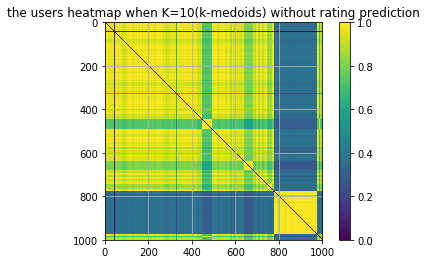

In [429]:
plt.imshow(x1, interpolation='nearest')
plt.grid(True)
plt.colorbar()
plt.title('the users heatmap when K=10(k-medoids) without rating prediction')
plt.show()


Now we can compute the Cumulative distribution function in term of the frequency of each pair of items via the function cdf with K range from 3 to 8.also,we defined the function deltaA to compute the area under cdf line,which can give us clues to find the best K.the deltaA can be defined as below:
$$A(K)=\sum_{i=2}^m[a_i-a_{i-1}]CDF(a_i)$$
<br> where $\{a_1,a_2...a_i\}$ represent the sorted elements of consensus matrix $C\_M^{(k)}$ 

In [440]:
import statsmodels.api as sm

def cdf(A,number,a):
    list1=[]
    for i in range(len(A)):
        for j in range(i):
            list1.append(A[i][j])
    a=np.array(list1)
    ecdf = sm.distributions.ECDF(a)
    x = np.linspace(min(a), max(a),number)
    y = ecdf(x)
    plt.plot(x, y,label=a)
    

def deltaA(A):
    list1=[]
    for i in range(len(A)):
        for j in range(len(A)):
            list1.append(A[i][j])
    list2=np.sort(list1)
    deltaA1=list2[0]
    h=np.array(list2)
    ecdf = sm.distributions.ECDF(h)
    for i in range(len(list2)-1):
        deltaA1+=(list2[i+1]-list2[i])*ecdf(list2[i+1])
    return deltaA1



    

In [321]:
#warning : this could take relative long time to run.
a=con2(5,50,featureU)
b=con2(6,50,featureU)
c=con2(7,50,featureU)
d=con2(8,50,featureU)
e=con2(9,50,featureU)
f=con2(10,50,featureU)

/Users/Shared/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [322]:
a1=con2(5,50,featureP)
b1=con2(6,50,featureP)
c1=con2(7,50,featureP)
d1=con2(8,50,featureP)
e1=con2(9,50,featureP)
f1=con2(10,50,featureP)

/Users/Shared/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)



With the consensus matrix under different K values(from 2 to 5), the corresponding CDF of matrix values(K-medoids) can be plot as below, which overall  shown a Roughly climbing trend of all the curves.

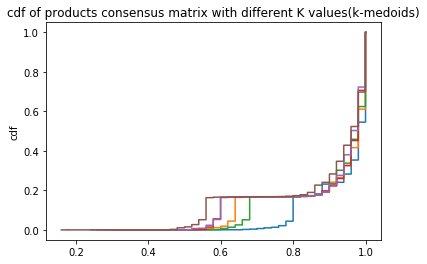

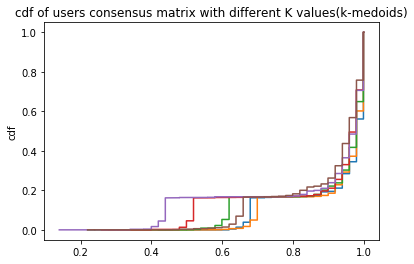

In [325]:
#plt.subplot()
p=cdf(a,1000,'K=2')
p1=cdf(b,1000,'K=3')
p2=cdf(c,1000,'K=4')
p3=cdf(d,1000,'K=5')
p4=cdf(e,1000,'K=6')
p5=cdf(f,1000,'K=7')
plt.ylabel('cdf')
plt.title('cdf of products consensus matrix with different K values(k-medoids)'
         )
plt.subplots()
p=cdf(a1,1000,'K=2')
p1=cdf(b1,1000,'K=3')
p2=cdf(c1,1000,'K=4')
p3=cdf(d1,1000,'K=5')
p4=cdf(e1,1000,'K=6')
p5=cdf(f1,1000,'K=7')
plt.ylabel('cdf')
plt.title('cdf of users consensus matrix with different K values(k-medoids)'
         )

## procession of  consensus clustering(K-means) without recommend system and link prediction

 In this part, we are still utilise consensus clustering as the basic principle but change the clustering method from K-medoids to K-means,If k is given, the K-means algorithm can be executed in the following steps:
<br>1.Partition of objects into k non-empty subsets
<br>2.Identifying the cluster centroids (mean point) of the current <br>3.partition.
<br>4.Assigning each point to a specific cluster
<br>5.Compute the distances from each point and allot points to the cluster where the distance from the centroid is minimum.
<br>6.After re-allotting the points, find the centroid of the new cluster formed.
<br>now we can encode this argorithm as below:

In [326]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

def kmeans1(features,k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    list1=list(range(1000))
    return labels[:1000]

In [327]:
def kmeans2(D,k,dict2):
    kme=kmeans1(D,k)
    kme1=[]
    for i in dict2:
        a=dict2.index(i)
        kme1.append(kme[i[0]])
    return kme1

In [328]:
def meancon2(kind,resa,features):
    m=1000
    c=np.zeros([m,1])
    A=np.zeros([m,m])
    kk=kind
    dict2= kmeans1(features,kind)
    try1=conseq(dict2)
    for i in range(resa):
        refeatures=resample(features,i)
        c=kmeans2(refeatures,kk,try1)     
        for l in range(0,m):
            for j in range(l+1,m):
                if c[l]==c[j]:
                    A[l][j]+=1
                    A[j][l]=A[l][j]
    con2=A/resa   
    return con2

We choose K=10 as an instance,now we can compute the consensus matrix.

In [372]:
y1=meancon2(10,50,featureU)


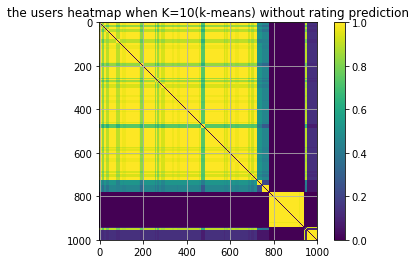

In [500]:
plt.imshow(y1, interpolation='nearest')
plt.grid(True)
plt.colorbar()
plt.title('the users heatmap when K=10(k-means) without rating prediction'
         )
plt.show()

Now we can plot the empirical cumulative distribution function(CDF) of K-means,it also has same trend with K-medoids.

In [354]:
g=meancon2(5,50,featureU)
h=meancon2(6,50,featureU)
i=meancon2(7,50,featureU)
j=meancon2(8,50,featureU)
k=meancon2(9,50,featureU)
l=meancon2(10,50,featureU)

In [355]:
g1=meancon2(5,50,featureP)
h1=meancon2(6,50,featureP)
i1=meancon2(7,50,featureP)
j1=meancon2(8,50,featureP)
k1=meancon2(9,50,featureP)
l1=meancon2(10,50,featureP)

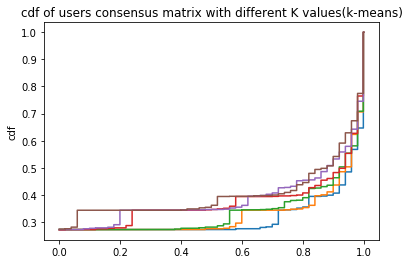

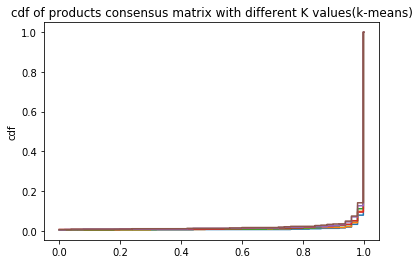

In [431]:
 
p=cdf(g,1000,'K=5')
p1=cdf(h,1000,'K=6')
p2=cdf(i,1000,'K=7')
p3=cdf(j,1000,'K=8')
p4=cdf(k,1000,'K=9')
p5=cdf(l,1000,'K=10')
plt.ylabel('cdf')
plt.title('cdf of users consensus matrix with different K values(k-means)'
         )
plt.subplots()
p=cdf(g1,1000,'K=5')
p1=cdf(h1,1000,'K=6')
p2=cdf(i1,1000,'K=7')
p3=cdf(j1,1000,'K=8')
p4=cdf(k1,1000,'K=9')
p5=cdf(l1,1000,'K=10')
plt.ylabel('cdf')
plt.title('cdf of products consensus matrix with different K values(k-means)'
         )

## procession of  consensus clustering(K-medoids) with  recommender system

We used a portion(2000 rows) of the Amazon Fine Food Reviews dataset to test our methodology and with it several matrices were created by rating prediction (ConvMF)(Mario's work) and link prediction(yue's work),based on  it,we now re-compute the consensus matrix via K-medoids and K-means respectively.

In [358]:
R1 = np.load('/Users/dongwen/Desktop/wen dong/prediction samples.npy')

In [359]:
R=R1[:2000][:2000]

the adjacent matrix can now represented as below:

In [361]:
featureU1=R
featureP1=np.transpose(R)
print(R)

[[ 1.72527533  1.69626584  1.73487896 ...,  1.81711099  2.00956568
   1.96402667]
 [ 0.34297821  0.33724649  0.34485186 ...,  0.36102534  0.39893417
   0.38997223]
 [ 1.3832302   1.35983079  1.39107214 ...,  1.45769851  1.6133997
   1.57651996]
 ..., 
 [ 1.74237035  1.70873278  1.75648876 ...,  1.86126686  2.09802381
   2.03738158]
 [ 1.77140136  1.73998856  1.78289377 ...,  1.87542406  2.09436848
   2.04263317]
 [ 1.74237035  1.70873278  1.75648876 ...,  1.86126686  2.09802381
   2.03738158]]


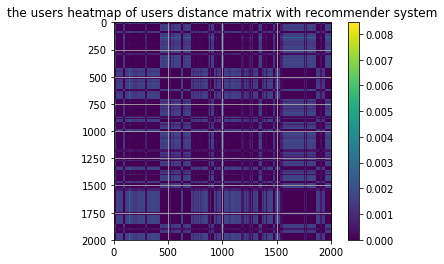

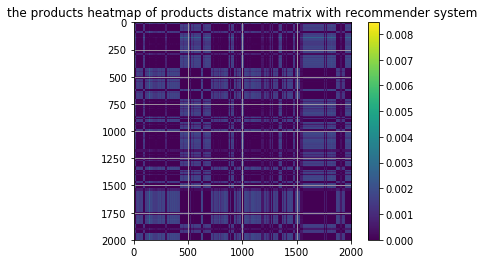

In [364]:
distanceU=1-np.corrcoef(featureU1)
distanceP=1-np.corrcoef(featureP1)
plt.imshow(distanceU, interpolation='nearest')
plt.grid(True)
plt.colorbar()
plt.title('the users heatmap of users distance matrix with recommender system')
plt.subplots()
plt.imshow(distanceU, interpolation='nearest')
plt.grid(True)
plt.colorbar()
plt.title('the products heatmap of products distance matrix with recommender system')
plt.show()


Also,we choose K=8 as a exampletThe heatmap consensus matrix with K=8 and K-medoids were shown below, whose blocks were divided well for the users:

In [378]:

z2=con2(8,50,featureU1)

/Users/Shared/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


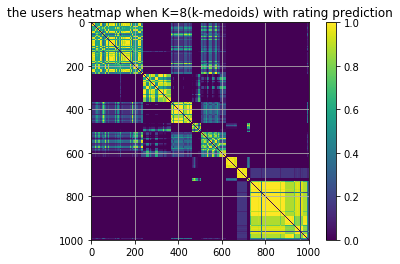

In [422]:

plt.imshow(z2, interpolation='nearest')
plt.grid(True)
plt.colorbar()
plt.title('the users heatmap when K=8(k-medoids) with rating prediction'
         )
plt.show()

In [417]:
pu2=con2(2,50,featureU1)
pu3=con2(3,50,featureU1)
pu4=con2(4,50,featureU1)
pu5=con2(5,50,featureU1)The corresponding CDFs of K-medoids consensus matrix were like the figures below, as which has been mentioned above, the delta_A function were introduced for  finding the most stable K values when reached the peak of the curves. It can be proved when K=3, both the users and products have the most stable clusters for K-medoids.

pu6=con2(6,50,featureU1)
pu7=con2(7,50,featureU1)
pu8=con2(8,50,featureU1)
pu9=con2(9,50,featureU1)
pu10=con2(10,50,featureU1)
pu11=con2(11,50,featureU1)


/Users/Shared/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 The corresponding CDFs of K-medoids consensus matrix were like the figures below, as which has been mentioned above.


In [418]:
pp2=con2(2,50,featureP1)
pp3=con2(3,50,featureP1)
pp4=con2(4,50,featureP1)
pp5=con2(5,50,featureP1)
pp6=con2(6,50,featureP1)
pp7=con2(7,50,featureP1)
pp8=con2(8,50,featureP1)
pp9=con2(9,50,featureP1)
pp10=con2(10,50,featureP1)
pp11=con2(11,50,featureP1)

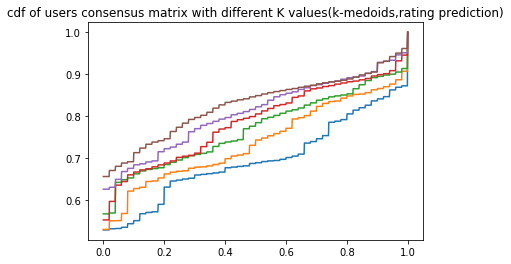

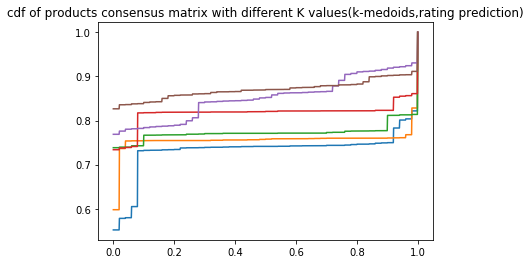

In [471]:
p=cdf(pu5,1000,'K=5')
p1=cdf(pu6,1000,'K=6')
p2=cdf(pu7,1000,'K=7')
p3=cdf(pu8,1000,'K=8')
p4=cdf(pu9,1000,'K=9')
pd5=cdf(pu10,1000,'K=10')

plt.title('cdf of users consensus matrix with different K values(k-medoids,rating prediction)')
plt.subplots()
p=cdf(pp5,1000,'K=5')
p1=cdf(pp6,1000,'K=6')
p2=cdf(pp7,1000,'K=7')
p3=cdf(pp8,1000,'K=8')
p4=cdf(pp9,1000,'K=9')
pd5=cdf(pp10,1000,'K=10')
plt.title('cdf of products consensus matrix with different K values(k-medoids,rating prediction)')

 the delta_A function were introduced for  finding the most stable K values when reached the peak of the curves. It can be proved when K=3, both the users and products have the most stable clusters for K-medoids.


In [131]:
np.save('users_distancematrix', featureU1)
np.save('products_distancematrix', featurep1)

In [392]:
s2=(deltaA(pu3)-deltaA(pu2))/deltaA(pu2)
s3=(deltaA(pu4)-deltaA(pu3))/deltaA(pu3)
s4=(deltaA(pu5)-deltaA(pu4))/deltaA(pu4)
s5=(deltaA(pu6)-deltaA(pu5))/deltaA(pu5)
s6=(deltaA(pu7)-deltaA(pu6))/deltaA(pu6)
s7=(deltaA(pu8)-deltaA(pu7))/deltaA(pu7)
s8=(deltaA(pu9)-deltaA(pu8))/deltaA(pu8)
s9=(deltaA(pu10)-deltaA(pu9))/deltaA(pu9)
s10=(deltaA(pu11)-deltaA(pu10))/deltaA(pu10)

print(s2,s3,s4,s5,s6,s7,s8,s9,s10)

-0.152519748828 0.159457035808 0.0747543315259 0.0680211154499 0.0471336774069 0.0120208530509 0.0297244486769 0.0251519261404 0.0206359115201


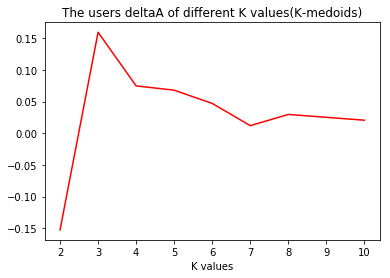

In [472]:
s=list((s2,s3,s4,s5,s6,s7,s8,s9,s10))
Kvalue=((2,3,4,5,6,7,8,9,10))
plt.plot(Kvalue,s,'r')
plt.xlabel('K values')
#plt.ylabel('delta A')

plt.title('The users deltaA of different K values(K-medoids)')

In [399]:
sp2=(deltaA(pp3)-deltaA(pp2))/deltaA(pp2)
sp3=(deltaA(pp4)-deltaA(pp3))/deltaA(pp3)
sp4=(deltaA(pp5)-deltaA(pp4))/deltaA(pp4)
sp5=(deltaA(pp6)-deltaA(pp5))/deltaA(pp5)
sp6=(deltaA(pp7)-deltaA(pp6))/deltaA(pp6)
sp7=(deltaA(pp8)-deltaA(pp7))/deltaA(pp7)
sp8=(deltaA(pp9)-deltaA(pp8))/deltaA(pp8)
sp9=(deltaA(pp10)-deltaA(pp9))/deltaA(pp9)
sp10=(deltaA(pp11)-deltaA(pp10))/deltaA(pp10)


[-0.49146615999999999, 0.2489601871922624, 0.17136671225672154, 0.025077981922420011, 0.019933083816844274, 0.060734751195927812, 0.037312834794304521, 0.020227573581028099, 0.019204757308313995]


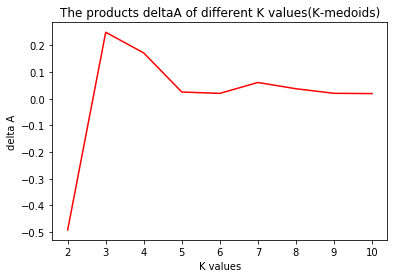

In [410]:

s=list((sp2,sp3,sp4,sp5,sp6,sp7,sp8,sp9,sp10))
Kvalue=((2,3,4,5,6,7,8,9,10))
plt.plot(Kvalue,s,'r')
plt.xlabel('K values')
plt.ylabel('delta A')
plt.title('The products deltaA of different K values(K-medoids)')
print(s)


In [476]:
z2=con2(3,50,featureP1)
m2=con2(3,50,featureU1)

/Users/Shared/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 After finding the most stable matrix(K=3), the consensus heatmap of users and products were shown respectively:

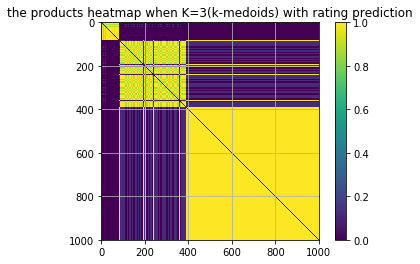

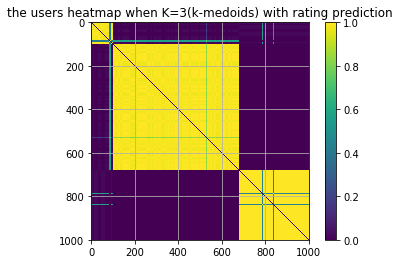

In [479]:
plt.imshow(z2, interpolation='nearest')
plt.grid(True)
plt.colorbar()
plt.title('the products heatmap when K=3(k-medoids) with rating prediction'
         )
plt.subplots()
plt.imshow(m2, interpolation='nearest')
plt.grid(True)
plt.colorbar()
plt.title('the users heatmap when K=3(k-medoids) with rating prediction'
         )
plt.show()

## procession of  consensus clustering(K-means) with recommend system

When it comes to the consensus clustering of  K-means,The heatmap consensus matrix with K=8 were shown below, whose blocks were divided well .


In [401]:
pz1=meancon2(8,50,featureU1)

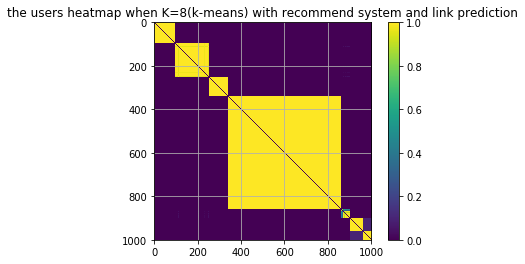

In [432]:
plt.imshow(pz1, interpolation='nearest')
plt.grid(True)
plt.colorbar()
plt.title('the users heatmap when K=8(k-means) with recommend system and link prediction')
plt.show()

When it comes to the consensus clustering of  K-means, the CDFs function and delta_A function were also like K-medoids ever used, the most reliable K values can be observed when it equaled 2 and 3 for users and products respectively.


In [403]:
mu2=meancon2(2,50,featureU1)
mu3=meancon2(3,50,featureU1)
mu4=meancon2(4,50,featureU1)
mu5=meancon2(5,50,featureU1)
mu6=meancon2(6,50,featureU1)
mu7=meancon2(7,50,featureU1)
mu8=meancon2(8,50,featureU1)
mu9=meancon2(9,50,featureU1)
mu10=meancon2(10,50,featureU1)
mu11=meancon2(11,50,featureU1)

In [404]:
mp2=meancon2(2,50,featureP1)
mp3=meancon2(3,50,featureP1)
mp4=meancon2(4,50,featureP1)
mp5=meancon2(5,50,featureP1)
mp6=meancon2(6,50,featureP1)
mp7=meancon2(7,50,featureP1)
mp8=meancon2(8,50,featureP1)
mp9=meancon2(9,50,featureP1)
mp10=meancon2(10,50,featureP1)
mp11=meancon2(11,50,featureP1)

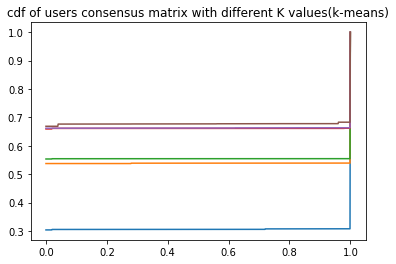

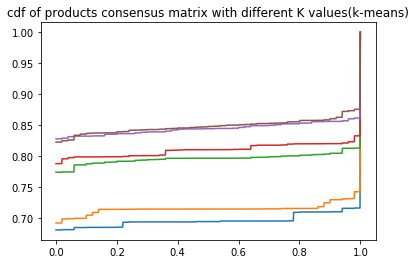

In [450]:

p=cdf(mu2,1000,'K=5')
p1=cdf(mu3,1000,'K=5')
p2=cdf(mu4,1000,'K=5')
p3=cdf(mu5,1000,'K=5')
p4=cdf(mu6,1000,'K=9')
pd5=cdf(mu7,1000,'K=10')
#plt.ylabel('cdf')
plt.title('cdf of users consensus matrix with different K values(k-means)')
plt.subplots()
p=cdf(mp5,1000,'K=5')
p1=cdf(mp6,1000,'K=6')
p2=cdf(mp7,1000,'K=7')
p3=cdf(mp8,1000,'K=8')
p4=cdf(mp9,1000,'K=9')
pd5=cdf(mp10,1000,'K=10')
#plt.ylabel('cdf')
plt.title('cdf of products consensus matrix with different K values(k-means)')

In [406]:
sm2=(deltaA(mu3)-deltaA(mu2))/deltaA(mu2)
sm3=(deltaA(mu4)-deltaA(mu3))/deltaA(mu3)
sm4=(deltaA(mu5)-deltaA(mu4))/deltaA(mu4)
sm5=(deltaA(mu6)-deltaA(mu5))/deltaA(mu5)
sm6=(deltaA(mu7)-deltaA(mu6))/deltaA(mu6)
sm7=(deltaA(mu8)-deltaA(mu7))/deltaA(mu7)
sm8=(deltaA(mu9)-deltaA(mu8))/deltaA(mu8)
sm9=(deltaA(mu10)-deltaA(mu9))/deltaA(mu9)
sm10=(deltaA(mu11)-deltaA(mu10))/deltaA(mu10)

print(sm2,sm3,sm4,sm5,sm6,sm7,sm8,sm9,sm10)

1.07971225901 -0.156210538537 0.186060876655 0.00140080997614 0.0310483292829 -0.00286131708158 0.00218564577471 0.0109957945528 0.0206284500492


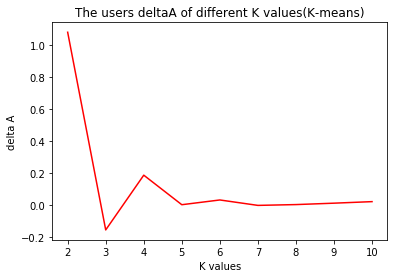

In [407]:
s=list((sm2,sm3,sm4,sm5,sm6,sm7,sm8,sm9,sm10))
Kvalue=((2,3,4,5,6,7,8,9,10))
plt.plot(Kvalue,s,'r')
plt.xlabel('K values')
plt.ylabel('delta A')
plt.title('The users deltaA of different K values(K-means)')

In [408]:
smp2=(deltaA(mp3)-deltaA(mp2))/deltaA(mp2)
smp3=(deltaA(mp4)-deltaA(mp3))/deltaA(mp3)
smp4=(deltaA(mp5)-deltaA(mp4))/deltaA(mp4)
smp5=(deltaA(mp6)-deltaA(mp5))/deltaA(mp5)
smp6=(deltaA(mp7)-deltaA(mp6))/deltaA(mp6)
smp7=(deltaA(mp8)-deltaA(mp7))/deltaA(mp7)
smp8=(deltaA(mp9)-deltaA(mp8))/deltaA(mp8)
smp9=(deltaA(mp10)-deltaA(mp9))/deltaA(mp9)
smp10=(deltaA(mp11)-deltaA(mp10))/deltaA(mp10)

print(smp2,smp3,smp4,smp5,smp6,smp7,smp8,smp9,smp10)

-0.54931152 0.393371048668 0.119755478662 0.0262196352945 0.109880227323 0.0168285902943 0.0413616825228 0.00435666353407 0.0265105749261


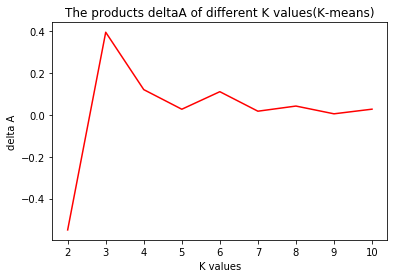

In [409]:
s=list((smp2,smp3,smp4,smp5,smp6,smp7,smp8,smp9,smp10))
Kvalue=((2,3,4,5,6,7,8,9,10))
plt.plot(Kvalue,s,'r')
plt.xlabel('K values')
plt.ylabel('delta A')
plt.title('The products deltaA of different K values(K-means)')

After finding the most stable matrix(K=2 when users and K=3 when products), the consensus heatmap of users and products were shown as below.


In [540]:
zm2=meancon2(3,50,featureP1)
mm2=meancon2(2,50,featureU1)

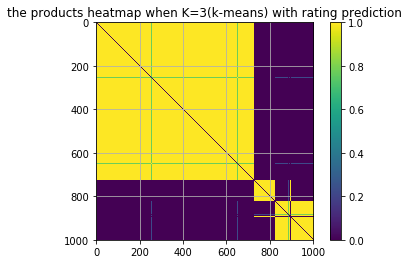

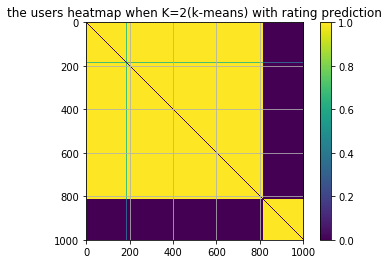

In [541]:
plt.imshow(zm2, interpolation='nearest')
plt.grid(True)
plt.colorbar()
plt.title('the products heatmap when K=3(k-means) with rating prediction'
         )
plt.subplots()
plt.imshow(mm2, interpolation='nearest')
plt.grid(True)
plt.colorbar()
plt.title('the users heatmap when K=2(k-means) with rating prediction'
         )
plt.show()

In term of users,we are now cluster the 2000 samples when K=3 for k-medoids and K=2 for K-means.

In [570]:
dict2= kmeans4(featureU1,2)
distance1=1-np.corrcoef(featureU1)
dict3= kMedoids4(distance1,3)

In [571]:
for i in range(3):
    print(len(dict3[i]))
from collections import Counter
Counter(dict2)


1028
245
727


Counter({0: 1630, 1: 370})

In [572]:

dict4={0:list(),1:list()}
for j in range(3):
    for i in range(len(dict2)):
        if j==dict2[i]:
            dict4[j].append(i) 
for i in range(2):
    dict4[i]=np.array([dict4[i]])        
            

In [573]:
print('the K=3 usres clusters for K-medoids are:',dict3)
print('the K=2 usres clusters for K-means are:',dict4)


the K=3 usres clusters for K-medoids are: {0: array([   0,    1,    2, ..., 1936, 1937, 1998]), 1: array([   8,   31,   34,   44,   51,   52,   76,   78,  101,  132,  179,
        181,  185,  216,  244,  284,  285,  286,  287,  288,  289,  290,
        291,  292,  293,  294,  295,  296,  297,  298,  299,  300,  301,
        302,  333,  365,  381,  384,  402,  403,  418,  423,  431,  438,
        441,  458,  466,  478,  500,  502,  510,  513,  517,  518,  519,
        550,  553,  557,  563,  566,  575,  588,  590,  597,  604,  605,
        630,  632,  636,  659,  663,  666,  713,  727,  728,  729,  730,
        731,  732,  733,  734,  735,  736,  792,  793,  794,  795,  796,
        797,  798,  799,  800,  818,  846,  866,  868,  871,  885,  940,
        990, 1044, 1054, 1061, 1073, 1075, 1084, 1165, 1166, 1167, 1168,
       1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179,
       1180, 1181, 1182, 1183, 1184, 1186, 1187, 1188, 1189, 1215, 1216,
       1217, 1218, 1219, 

In [575]:
np.save('K=2,users,k-means', dict4)
np.save('K=3,users,K-medoids',dict3)